In [2]:
import convex_return_mapping as crm # there is a conflict in the oder of imported modules

from mpi4py import MPI

import plasticity_framework as pf
# import sys
# sys.path.append("../")
# import fenicsx_support as fs

import matplotlib.pyplot as plt
import numpy as np

import logging

In [3]:
def plot_dsiplacement(results):
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"img/displacement_rank{MPI.COMM_WORLD.rank:d}.png")

In [4]:
Pa_dim = 70e3
E = 70e3 / Pa_dim #[-]
nu = 0.3 #[-]
sig0 = 250 / Pa_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

vonMises = crm.vonMises(sig0, H)
material_vM = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)

alpha = 0
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

sigt = 250 / Pa_dim
sigc = 250 / Pa_dim

Rankine = crm.Rankine(sigt, sigc, H)
material_Rankine = crm.Material(crm.IsotropicElasticity(E, nu), Rankine)

In [5]:
logger = logging.getLogger('analysis')
logger.setLevel(logging.INFO)
logger.setLevel(pf.LOG_INFO_STAR)
# logger.setLevel(logging.WARNING)

logger_file = logging.getLogger('analysis_file')
logger_file.setLevel(logging.DEBUG)
# logger_file.setLevel(logging.INFO)
logger_file.setLevel(pf.LOG_INFO_STAR)
fh = logging.FileHandler("log/plasticity_analysis.log", mode='a')
logger_file.addHandler(fh)

In [5]:
# plasticity_std = pf.vonMisesPlasticity(material_vM, logger=logger, solver='SNESQN', mesh_name="thick_cylinder_coarse.msh")
# plasticity_DP = pf.DruckerPragerPlasticity(material_DP, logger=logger, solver='SNESQN', mesh_name="thick_cylinder_coarse.msh")
# plasticity_convex_analytical_DP = pf.ConvexAnalyticalPlasticity(material_DP, logger=logger_file, solver='SNESQN', mesh_name="thick_cylinder_coarse.msh", patch_size=10, conic_solver='SCS')
# plasticity_convex_DP = pf.ConvexPlasticity(material_DP, logger=logger, solver='SNESQN', mesh_name="thick_cylinder_coarse.msh", patch_size=100)

## Patches size

In the case of von Mises material and SNESQN solver

In [5]:
alpha = 0
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

In [ ]:
# patch_sizes = [1, 3 , 5, 10, 100, 207]
patch_sizes = [1, 3, 5, 10, 20, 30, 40, 50, 80, 100, 207]
# patch_sizes = [100, 207]
time_coarse_mesh = []
for size in patch_sizes:
    logger_file.log(pf.LOG_INFO_STAR, f'patch size = {size}')
    plasticity_convex = pf.ConvexPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name="mesh/thick_cylinder_coarse.msh", patch_size=size)
    _, _, T, _, _, _ = plasticity_convex.solve()
    time_coarse_mesh.append(T)

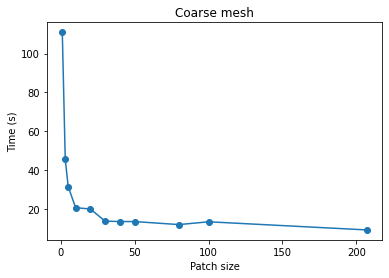

In [7]:
plt.xlabel("Patch size")
plt.ylabel("Time (s)")
plt.title('Coarse mesh')
plt.plot(patch_sizes, time_coarse_mesh, "-o")
plt.savefig("img/patch_sizes_coarse.png")

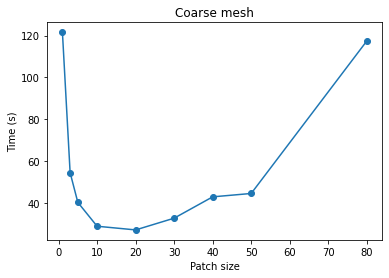

In [ ]:
plt.xlabel("Patch size")
plt.ylabel("Time (s)")
plt.title('Coarse mesh')
plt.plot(patch_sizes, time_coarse_mesh, "-o")
plt.savefig("img/patch_sizes_coarse.png")

## 

In [ ]:
patch_sizes = [1, 3, 5, 10, 20, 30, 40, 50, 80]
time_medium_mesh = []
for size in patch_sizes:
    logger_file.log(pf.LOG_INFO_STAR, f'patch size = {size}')
    plasticity_convex = pf.ConvexPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name="thick_cylinder.msh", patch_size=size)
    _, _, T, _, _, _ = plasticity_convex.solve()
    time_medium_mesh.append(T)

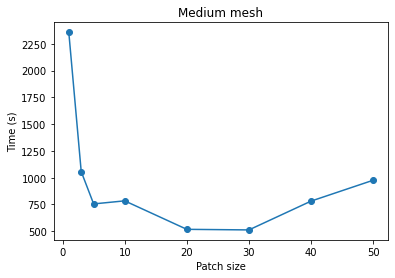

In [ ]:
plt.xlabel("Patch size")
plt.ylabel("Time (s)")
plt.title('Medium mesh')
plt.plot(patch_sizes[:-1], time_medium_mesh, "-o")
plt.savefig("img/patch_sizes_medium.png")

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(40,5))
# for i, alpha in enumerate(alphas):
#     ax[i].set_title(r'$\alpha = $' + str(alpha))
#     ax[i].plot(results_SNES_list[i][:, 0], results_SNES_list[i][:, 1], "-o", label='SNES')
#     ax[i].plot(results_convex_list[i][:, 0], results_convex_list[i][:, 1], "-o", label='convex')
#     ax[i].set_xlabel("Patch size")
#     ax[i].set_ylabel("Time (s)")

## Conic solvers

In [ ]:
# MESH DATA
# coarse: 50 nodes (global), 69 cells (global), 207 quadrature_points (global)
# medium: 407 nodes (global), 714 cells (global), 2142 quadrature_points (Q2 space) 
# 811 nodes (global), 1478 cells (global), 4434 quadrature_points (global)
# 2121 nodes (global), 4240 cells (global),  quadrature_points (global)
print(407/50, 714/69, 2142/207)
print(811/407, 1478/714, 4434/2142)
print(2121/811, 4240/1478)

8.14 10.347826086956522 10.347826086956522
1.9926289926289926 2.070028011204482 2.070028011204482
2.615289765721332 2.8687415426251692


### Coarse mesh

In [ ]:
conic_solvers = ['SCS', 'ECOS', 'MOSEK']
conic_solvers = ['MOSEK']

patch_sizes = [1, 5, 10, 20, 30, 40, 50, 100, 150, 207]
patch_sizes = [40, 50, 100, 150, 207]

time_coarse_mesh = []
for conic_solver in conic_solvers:
    time = []
    for size in patch_sizes:
        logger_file.log(pf.LOG_INFO_STAR, f'conic solver = {conic_solver}, patch size = {size}')
        plasticity_convex = pf.ConvexPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name="thick_cylinder_coarse.msh", patch_size=size, conic_solver=conic_solver)
        _, _, T, _, _, _ = plasticity_convex.solve()
        time.append(T)
    time_coarse_mesh.append(time)

In [12]:
patch_sizes_MOSEK = [40, 100, 150, 207]
MOSEK_compile = np.array([0.41 - 0.31, 0.37 - 0.19, 0.34 - 0.15, 0.45 - 0.13])
MOSEK = [58.45, 22.84, 19.86, 15.67]

patch_sizes = [1, 5, 10, 20, 30, 40, 50, 100, 150, 207]

ECOS_compile = np.array([0, 0.33 - 0.27, 0.25 - 0.18, 0.23 - 0.16, 0.21 - 0.15, 0.2 - 0.14, 0.21 - 0.15, 0.24 - 0.13, 0.35 - 0.15, 0.38 - 0.12])
ECOS = [127.61, 32.85, 20.87, 16.49, 15.15, 16, 16.13, 14.93, 15.22, 14.59]

SCS_compile = np.array([0.93 - 0.85, 0.22 - 0.20, 0.18 - 0.13, 0.19 - 0.13, 0.15 - 0.09, 0.13 - 0.09, 0.14 - 0.09, 0.19 - 0.09, 0.29 - 0.09, 0.38 - 0.06])
SCS = [116.28, 33.97, 22.78, 22.33, 14.45, 14.71, 13.52, 13.05, 9.79, 10.12]

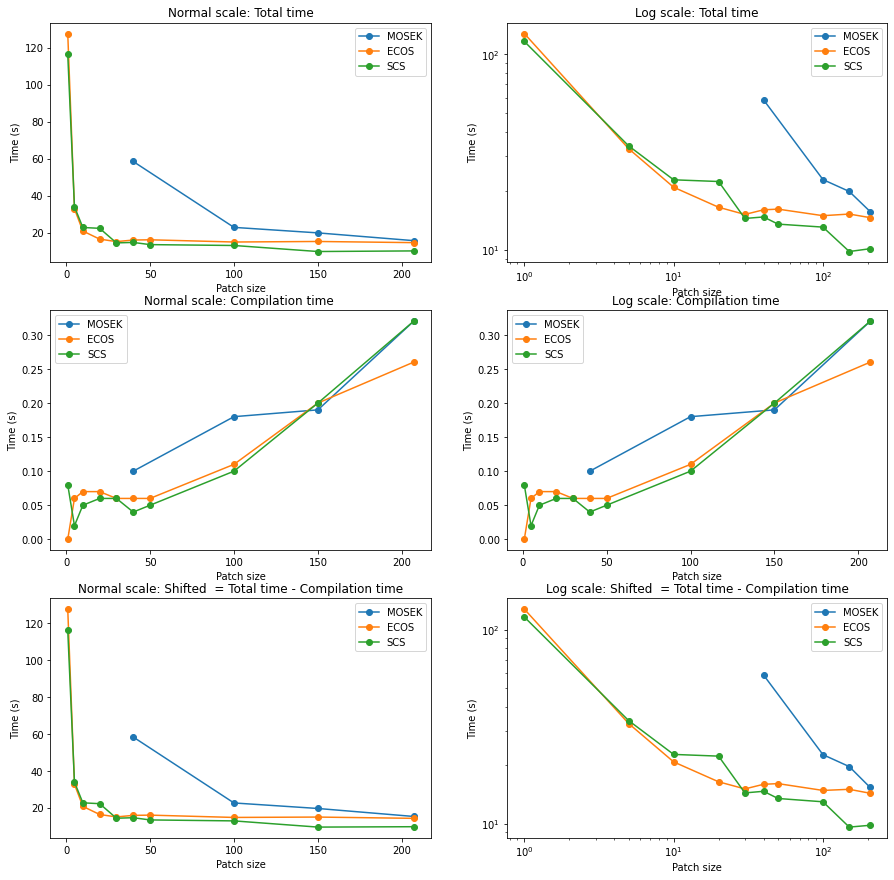

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

# fig.suptitle('Coarse mesh')

ax[0][0].set_title('Normal scale: Total time')
ax[0][0].plot(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][0].plot(patch_sizes, ECOS, "-o", label='ECOS')
ax[0][0].plot(patch_sizes, SCS, "-o", label='SCS')

ax[1][0].set_title('Normal scale: Compilation time ')
ax[1][0].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][0].plot(patch_sizes, ECOS_compile, "-o", label='ECOS')
ax[1][0].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][0].set_title('Normal scale: Shifted  = Total time - Compilation time')
ax[2][0].plot(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][0].plot(patch_sizes, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][0].plot(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

ax[0][1].set_title('Log scale: Total time')
ax[0][1].loglog(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][1].loglog(patch_sizes, ECOS, "-o", label='ECOS')
ax[0][1].loglog(patch_sizes, SCS, "-o", label='SCS')

ax[1][1].set_title('Log scale: Compilation time ')
ax[1][1].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][1].plot(patch_sizes, ECOS_compile, "-o", label='ECOS')
ax[1][1].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][1].set_title('Log scale: Shifted  = Total time - Compilation time')
ax[2][1].loglog(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][1].loglog(patch_sizes, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][1].loglog(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

for i in range(3):
    for j in range(2):
        ax[i][j].legend()
        ax[i][j].set_xlabel("Patch size")
        ax[i][j].set_ylabel("Time (s)")

plt.savefig("img/conic_solvers_coarse.png")
# fig.tight_layout()

### Medium mesh

In [ ]:
conic_solvers = ['ECOS', 'MOSEK']
patch_sizes = [5, 11, 50, 100, 500, 1000, 1500, 2000, 2142]
patch_sizes = [2]

time_coarse_mesh = []
for conic_solver in conic_solvers:
    time = []
    for size in patch_sizes:
        logger_file.log(pf.LOG_INFO_STAR, f'conic solver = {conic_solver}, patch size = {size}')
        plasticity_convex = pf.ConvexPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name="mesh/thick_cylinder_medium.msh", patch_size=size, conic_solver=conic_solver)
        _, _, T, _, _, _ = plasticity_convex.solve()
        time.append(T)
    time_coarse_mesh.append(time)

In [14]:
patch_sizes = [1, 5, 11, 50, 100, 500, 1000, 1500, 2000, 2142]

SCS_compile = np.array([0, 0, 0, 0, 0, 3.18-0.43, 17.24-0.53, 55.71-0.37, 130.40-0.7, 137.33-0.54])
SCS = [1051.34, 272.41, 193.5, 100.77, 92.66, 89.74, 111.77, 136.78, 227.48, 215.9]

patch_sizes_ECOS = [2, 5, 11, 50, 100, 500, 1000, 1500, 2000, 2142]
ECOS_compile = np.array([0, 0, 0, 0, 1.5-0.96, 4.66-1.07, 15.83-1.09, 46.38-1.37, 104.22-1.6, 125.02-1.7])
ECOS = [615.54, 271.98, 169.61, 115.65, 102.52, 117.64, 148.91, 180.93, 258.4, 301.06]

patch_sizes_MOSEK = [2, 5, 11, 51, 100, 500, 1000, 1500, 2000, 2142]
MOSEK_compile = np.array([0, 0, 0, 2.1-1.85, 1.86-1.4, 6.26-0.97, 20.89-0.92, 60.21-0.87, 121.66-0.88, 142.2-0.9])
MOSEK = [2947.84, 1381.5, 642.78, 251.81, 167.92, 127.39, 127.78, 161.14, 223.38, 239.37]

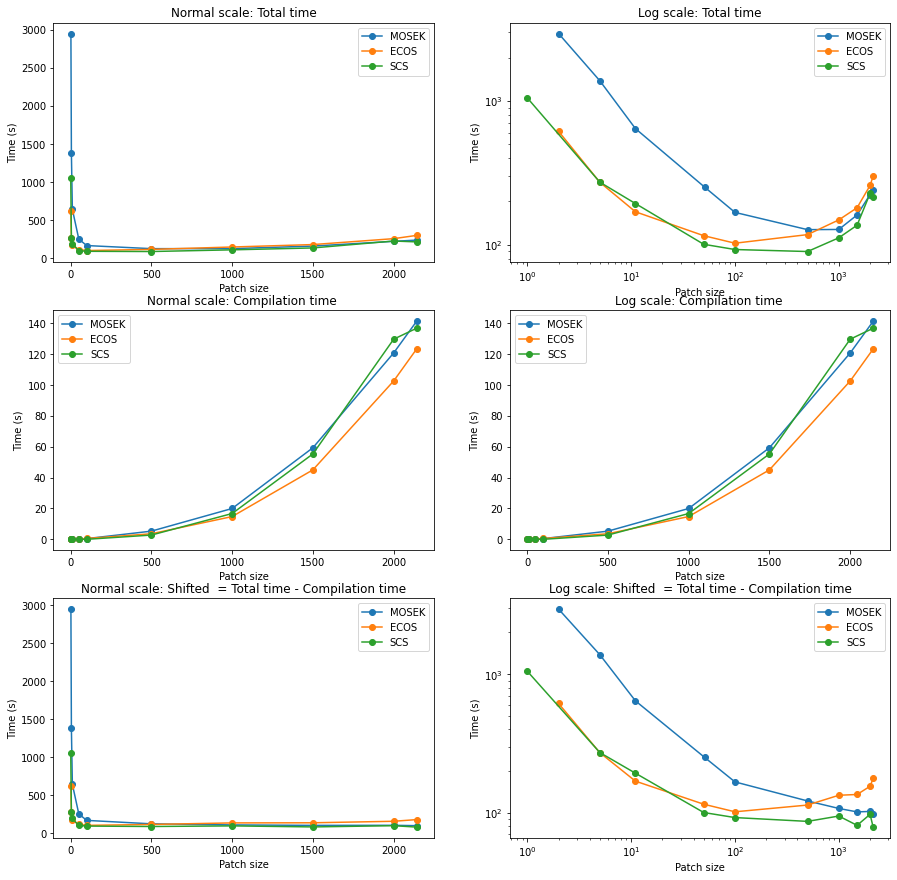

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

# fig.suptitle('Medium mesh')

ax[0][0].set_title('Normal scale: Total time')
ax[0][0].plot(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][0].plot(patch_sizes_ECOS, ECOS, "-o", label='ECOS')
ax[0][0].plot(patch_sizes, SCS, "-o", label='SCS')

ax[1][0].set_title('Normal scale: Compilation time ')
ax[1][0].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][0].plot(patch_sizes_ECOS, ECOS_compile, "-o", label='ECOS')
ax[1][0].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][0].set_title('Normal scale: Shifted  = Total time - Compilation time')
ax[2][0].plot(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][0].plot(patch_sizes_ECOS, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][0].plot(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

ax[0][1].set_title('Log scale: Total time')
ax[0][1].loglog(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][1].loglog(patch_sizes_ECOS, ECOS, "-o", label='ECOS')
ax[0][1].loglog(patch_sizes, SCS, "-o", label='SCS')

ax[1][1].set_title('Log scale: Compilation time ')
ax[1][1].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][1].plot(patch_sizes_ECOS, ECOS_compile, "-o", label='ECOS')
ax[1][1].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][1].set_title('Log scale: Shifted  = Total time - Compilation time')
ax[2][1].loglog(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][1].loglog(patch_sizes_ECOS, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][1].loglog(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

for i in range(3):
    for j in range(2):
        ax[i][j].legend()
        ax[i][j].set_xlabel("Patch size")
        ax[i][j].set_ylabel("Time (s)")

plt.savefig("img/conic_solvers_medium.png", dpi=300)
# fig.tight_layout()

### Main mesh

In [13]:
# plt.xlabel("Patch size")
# plt.ylabel("Time (s)")
# plt.title('Coarse mesh')
# for i, solver in enumerate(conic_solvers):
#     plt.plot(patch_sizes, time_coarse_mesh[i], "-o", label=solver)
# plt.legend()
# plt.savefig("img/conic_solvers_coarse_tmp.png")

In [ ]:
patch_sizes = [11, 50, 100, 500, 1000, 1500, 2000, 2500]
patch_sizes = [6] 

conic_solvers = ['MOSEK']

time_medium_mesh = []
for conic_solver in conic_solvers:
    time = []
    for size in patch_sizes:
        logger_file.log(pf.LOG_INFO_STAR, f'conic solver = {conic_solver}, patch size = {size}')
        plasticity_convex = pf.ConvexPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name="thick_cylinder.msh", patch_size=size, conic_solver=conic_solver, tol_conic_solver=1e-13)
        _, _, T, _, _, _ = plasticity_convex.solve()
        time.append(T)
        
    time_medium_mesh.append(time)

In [16]:
# # for patch_sizes = [?]
# SCS = [2123.34, 872.57, 640.29, 631.30, 481.87, 510.34, 829.08, 1000.69, 2770.39]

# # for patch_sizes = [250, 260, 270, 280, 290, 300]
# ECOS = [418.4926564693451, 406.2975263595581, 414.91892194747925, 436.04598736763, 396.418080329895, 499.7069659233093]

# # for patch_sizes = [2, 5, 10, 50, 100, 200, 250]
# MOSEK = [6490.76, 2741.61, 1494.32, 596.93, 464.96, 365.15]
# ECOS = [1582.5732097625732, 746.9019536972046, 553.5608420372009, 456.00735425949097, 377.7423219680786, 455.44888043403625, 480.2371971607208]
# SCS = [1274.89, 723.58, 716.88, 1079.78, 4432.63]

patch_sizes_MOSEK = [11, 100, 500, 1000, 1500, 2000, 2500]
MOSEK_compile = np.array([11.23 - 11.18, 2.45 - 2.17, 5.18 - 1.37, 17.99 - 1.47, 83.59 - 1.35, 103.33 - 1.26, 275.50 - 1.33])
MOSEK = [1200.69, 257.5, 185.26, 181.99, 238.70, 263.59, 431.19]

patch_sizes = [5, 11, 50, 100, 500, 1000, 1500, 2000, 2500]

ECOS_compile = np.array([5.38 - 5.29, 3.59 - 3.45, 2.38 - 2.02, 2.27 - 1.91, 9.18 - 2.13, 20.11 - 2.43, 92.29 - 2.79, 132.25 - 3.92, 312.07 - 3.6])
ECOS = [589.41, 346.44, 252.14, 202.98, 247.08, 307.42, 384.73, 553.61, 765.58]

SCS_compile = np.array([4.43 - 4.16, 0 , 1.14 - 0.99, 0.74 - 0.67, 8.37 - 0.70, 19.99 - 0.91, 89.15 - 0.84, 147.86 - 1.71, 316.31 - 1.43])
SCS = [611.43, 396.41, 227.36, 199, 207.03, 244.74, 281.36, 396.25, 502.30]

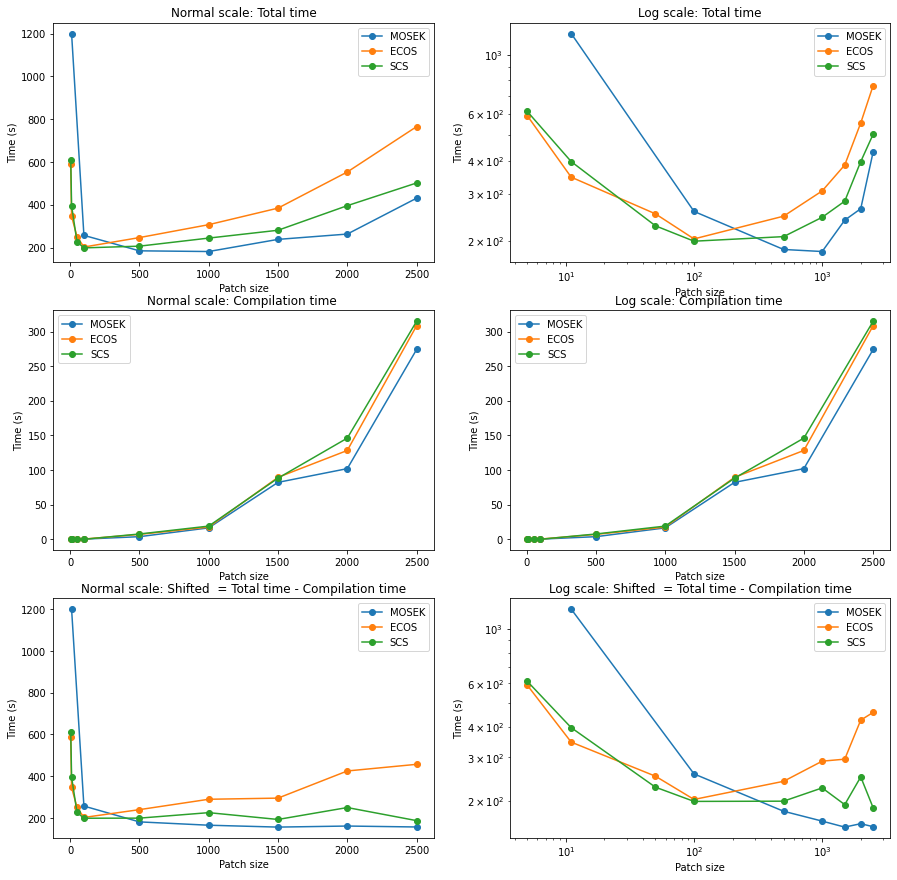

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

# fig.suptitle('Medium mesh')

ax[0][0].set_title('Normal scale: Total time')
ax[0][0].plot(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][0].plot(patch_sizes, ECOS, "-o", label='ECOS')
ax[0][0].plot(patch_sizes, SCS, "-o", label='SCS')

ax[1][0].set_title('Normal scale: Compilation time ')
ax[1][0].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][0].plot(patch_sizes, ECOS_compile, "-o", label='ECOS')
ax[1][0].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][0].set_title('Normal scale: Shifted  = Total time - Compilation time')
ax[2][0].plot(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][0].plot(patch_sizes, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][0].plot(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

ax[0][1].set_title('Log scale: Total time')
ax[0][1].loglog(patch_sizes_MOSEK, MOSEK, "-o", label='MOSEK')
ax[0][1].loglog(patch_sizes, ECOS, "-o", label='ECOS')
ax[0][1].loglog(patch_sizes, SCS, "-o", label='SCS')

ax[1][1].set_title('Log scale: Compilation time ')
ax[1][1].plot(patch_sizes_MOSEK, MOSEK_compile, "-o", label='MOSEK')
ax[1][1].plot(patch_sizes, ECOS_compile, "-o", label='ECOS')
ax[1][1].plot(patch_sizes, SCS_compile, "-o", label='SCS')

ax[2][1].set_title('Log scale: Shifted  = Total time - Compilation time')
ax[2][1].loglog(patch_sizes_MOSEK, MOSEK - MOSEK_compile, "-o", label='MOSEK')
ax[2][1].loglog(patch_sizes, ECOS - ECOS_compile, "-o", label='ECOS')
ax[2][1].loglog(patch_sizes, SCS - SCS_compile, "-o", label='SCS')

for i in range(3):
    for j in range(2):
        ax[i][j].legend()
        ax[i][j].set_xlabel("Patch size")
        ax[i][j].set_ylabel("Time (s)")

plt.savefig("img/conic_solvers.png", dpi=300)
# fig.tight_layout()

## Qualitative yield criterions comparison

In [14]:
vonMises = crm.vonMises(sig0, H)
material_vM = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)

alpha = 0

DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)

Rankine = crm.Rankine(sigt, sigc, H)
material_Rankine = crm.Material(crm.IsotropicElasticity(E, nu), Rankine)

In [15]:
plasticity_vM = pf.vonMisesPlasticity(material_vM, logger=logger_file, solver='nonlinear', mesh_name="thick_cylinder_coarse.msh")
plasticity_Rankine = pf.ConvexPlasticity(material_Rankine, logger=logger_file, solver='SNESQN', mesh_name="thick_cylinder_coarse.msh", patch_size=100, conic_solver='SCS')

Level 25:analysis_file:rank#0: mesh = thick_cylinder_coarse.msh
Level 25:analysis_file:rank#0: mesh info: 50 nodes (global), 69 cells (global), 207 quadrature_points (Q2 space) (global)
Level 25:analysis_file:rank#0: mesh info: 50 nodes (local), 69 cells (local), 207 quadrature_points (Q2 space) (local)


Level 25:analysis_file:rank#0: mesh = thick_cylinder_coarse.msh
Level 25:analysis_file:rank#0: mesh info: 50 nodes (global), 69 cells (global), 207 quadrature_points (Q2 space) (global)
Level 25:analysis_file:rank#0: mesh info: 50 nodes (local), 69 cells (local), 207 quadrature_points (Q2 space) (local)
Level 25:analysis_file:rank#0: Newton solver = SNESQN, conic solver = SCS, patch size = 100


In [16]:
results = []
_, result_vM, _, _, _, _ = plasticity_vM.solve()
results.append(result_vM)

Level 25:analysis_file:rank#0: Step: 1, Iterations = 1, Time = 0.07 (s)
Level 25:analysis_file:rank#0: Step: 2, Iterations = 1, Time = 0.06 (s)
Level 25:analysis_file:rank#0: Step: 3, Iterations = 1, Time = 0.05 (s)
Level 25:analysis_file:rank#0: Step: 4, Iterations = 1, Time = 0.05 (s)
Level 25:analysis_file:rank#0: Step: 5, Iterations = 1, Time = 0.06 (s)
Level 25:analysis_file:rank#0: Step: 6, Iterations = 1, Time = 0.05 (s)
Level 25:analysis_file:rank#0: Step: 7, Iterations = 1, Time = 0.05 (s)
Level 25:analysis_file:rank#0: Step: 8, Iterations = 1, Time = 0.06 (s)
Level 25:analysis_file:rank#0: Step: 9, Iterations = 1, Time = 0.05 (s)
Level 25:analysis_file:rank#0: Step: 10, Iterations = 1, Time = 0.07 (s)
Level 25:analysis_file:rank#0: Step: 11, Iterations = 1, Time = 0.07 (s)
Level 25:analysis_file:rank#0: Step: 12, Iterations = 4, Time = 0.20 (s)
Level 25:analysis_file:rank#0: Step: 13, Iterations = 4, Time = 0.19 (s)
Level 25:analysis_file:rank#0: Step: 14, Iterations = 4, Tim

In [17]:
_, result_Rankine, _, _, _, _ = plasticity_Rankine.solve()
results.append(result_Rankine)

Level 25:analysis_file:rank#0: Step: 1, Iterations = 1, Time = 3.64 (s)
Level 25:analysis_file:rank#0: Step: 2, Iterations = 1, Time = 0.35 (s)
Level 25:analysis_file:rank#0: Step: 3, Iterations = 1, Time = 0.39 (s)
Level 25:analysis_file:rank#0: Step: 4, Iterations = 1, Time = 0.42 (s)
Level 25:analysis_file:rank#0: Step: 5, Iterations = 1, Time = 0.39 (s)
Level 25:analysis_file:rank#0: Step: 6, Iterations = 1, Time = 0.39 (s)
Level 25:analysis_file:rank#0: Step: 7, Iterations = 1, Time = 0.37 (s)
Level 25:analysis_file:rank#0: Step: 8, Iterations = 1, Time = 0.39 (s)
Level 25:analysis_file:rank#0: Step: 9, Iterations = 1, Time = 0.39 (s)
Level 25:analysis_file:rank#0: Step: 10, Iterations = 1, Time = 0.36 (s)
Level 25:analysis_file:rank#0: Step: 11, Iterations = 1, Time = 0.41 (s)
Level 25:analysis_file:rank#0: Step: 12, Iterations = 1, Time = 0.46 (s)
Level 25:analysis_file:rank#0: Step: 13, Iterations = 1, Time = 0.41 (s)
Level 25:analysis_file:rank#0: Step: 14, Iterations = 13, Ti

In [ ]:
alphas = [0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.1, 1.3, 1.5, 2]
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity_DP = pf.DruckerPragerPlasticity(material_DP, logger=logger_file, solver='nonlinear', mesh_name="thick_cylinder_coarse.msh")
    _, result_DP, _, _, _, _ = plasticity_DP.solve()
    results.append(result_DP)

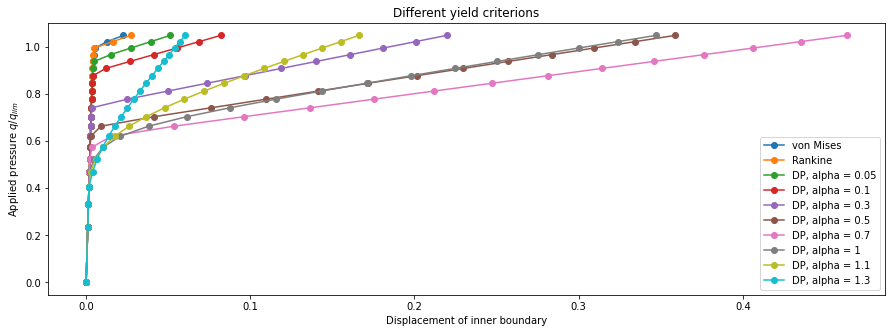

In [29]:
plt.figure(figsize=(15, 5))
plt.title('Different yield criterions')
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Applied pressure $q/q_{lim}$")
plt.plot(results[0][:,0], results[0][:,1], "-o", label='von Mises')
plt.plot(results[1][:,0], results[1][:,1], "-o", label='Rankine')

for i, alpha in enumerate(alphas[:-2]):
    plt.plot(results[i+2][:,0], results[i+2][:,1], "-o", label=f'DP, alpha = {alpha}')
plt.legend()
plt.savefig("img/yield_criterions.png")

## Calculation time for different approaches and solvers (for von Mises yield criterion)

### Classical approach vs Convex approach for a custom Newton solver

In [5]:
mesh = 'thick_cylinder_coarse.msh'
patch_size = 10
conic_solver = 'SCS'
solver = 'SNESQN'

# logger_file.log(pf.LOG_INFO_STAR, f'Newton solver = {solver}, conic solver = {conic_solver}, patch size = {patch_size}, mesh = {mesh}')
plasticity_convex = pf.ConvexAnalyticalPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name=mesh, patch_size=patch_size, conic_solver=conic_solver, tol_conic_solver=1e-13)
_, result, T, _, _, _ = plasticity_convex.solve()

Level 25:analysis_file:rank#0: mesh = thick_cylinder_coarse.msh
Level 25:analysis_file:rank#0: mesh info: 50 nodes (global), 69 cells (global), 207 quadrature_points (Q2 space) (global)
Level 25:analysis_file:rank#0: mesh info: 50 nodes (local), 69 cells (local), 207 quadrature_points (Q2 space) (local)
Level 25:analysis_file:rank#0: Newton solver = SNESQN, conic solver = SCS, patch size = 10
Level 25:analysis_file:rank#0: Step: 1, Iterations = 1, Time = 0.35 (s)
Level 25:analysis_file:rank#0: Step: 2, Iterations = 1, Time = 0.21 (s)
Level 25:analysis_file:rank#0: Step: 3, Iterations = 1, Time = 0.19 (s)
Level 25:analysis_file:rank#0: Step: 4, Iterations = 1, Time = 0.19 (s)
Level 25:analysis_file:rank#0: Step: 5, Iterations = 1, Time = 0.18 (s)
Level 25:analysis_file:rank#0: Step: 6, Iterations = 1, Time = 0.19 (s)
Level 25:analysis_file:rank#0: Step: 7, Iterations = 1, Time = 0.20 (s)
Level 25:analysis_file:rank#0: Step: 8, Iterations = 1, Time = 0.19 (s)
Level 25:analysis_file:rank#

In [ ]:
solvers = ['nonlinear', 'SNESQN']
meshes = ['thick_cylinder_coarse.msh', 'thick_cylinder.msh']

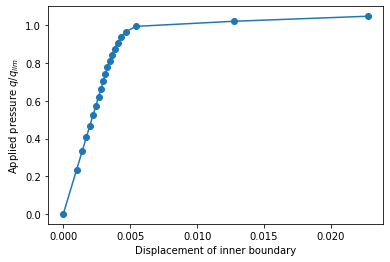

In [11]:
plot_dsiplacement(result)

In [12]:
mesh = 'thick_cylinder.msh'

logger_file.log(pf.LOG_INFO_STAR, f'Newton solver = {solver}, conic solver = {conic_solver}, patch size = {patch_size}, mesh = {mesh}')
plasticity_convex = pf.ConvexAnalyticalPlasticity(material_DP, logger=logger_file,  solver='SNESQN', mesh_name=mesh, patch_size=patch_size, conic_solver=conic_solver, tol_conic_solver=1e-13)
_, _, T, _, _, _ = plasticity_convex.solve()

Level 25:analysis_file:Newton solver = SNESQN, conic solver = SCS, patch size = 10, mesh = thick_cylinder.msh
Level 25:analysis_file:rank#0: mesh info: 811 nodes (global), 1478 cells (global), 4434 quadrature_points (global)
Level 25:analysis_file:rank#0: mesh info: 811 nodes (local), 1478 cells (local), 4434 quadrature_points (local)


Level 25:analysis_file:rank#0: Step: 1, Iterations = 1, Time = 3.54 (s)
Level 25:analysis_file:rank#0: Step: 2, Iterations = 1, Time = 3.27 (s)
Level 25:analysis_file:rank#0: Step: 3, Iterations = 1, Time = 3.25 (s)
Level 25:analysis_file:rank#0: Step: 4, Iterations = 1, Time = 3.20 (s)
Level 25:analysis_file:rank#0: Step: 5, Iterations = 1, Time = 3.22 (s)
Level 25:analysis_file:rank#0: Step: 6, Iterations = 1, Time = 3.29 (s)
Level 25:analysis_file:rank#0: Step: 7, Iterations = 1, Time = 3.14 (s)
Level 25:analysis_file:rank#0: Step: 8, Iterations = 1, Time = 3.43 (s)
Level 25:analysis_file:rank#0: Step: 9, Iterations = 1, Time = 3.59 (s)
Level 25:analysis_file:rank#0: Step: 10, Iterations = 1, Time = 3.67 (s)
Level 25:analysis_file:rank#0: Step: 11, Iterations = 5, Time = 11.87 (s)
Level 25:analysis_file:rank#0: Step: 12, Iterations = 11, Time = 25.63 (s)
Level 25:analysis_file:rank#0: Step: 13, Iterations = 13, Time = 29.20 (s)
Level 25:analysis_file:rank#0: Step: 14, Iterations = 1

### Classical approach vs Convex approach for SNESQN solver

### Difference between custom Newton solver and SNESQN solver

### Classical (with interpolation) approach vs Custom assembling 

## Testing part

In [ ]:
results_std_list = []
results_SNES_list = []
results_convex_list = []

In [ ]:
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity_std = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results_std = plasticity_std.solve()
    results_std_list.append(results_std)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.060 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.049 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.066 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.9920344941478264e-05, 1.6731017873775302
    Residual: 1.2634071442677747e-05, 0.5295066348646836
    Residual: 1.5772871600926973e-06, 0.06610569048507323
    Residual: 1.62887197096782e-09, 6.826766176571276e-

In [ ]:
results_convex_list = []
results_SNES_list = []

for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity_SNES = pf.StandardSNESDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")        
    _, results_SNES = plasticity_SNES.solve()
    results_SNES_list.append(results_SNES)

    plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=1, mesh_name="thick_cylinder_coarse.msh")
    _, results_convex = plasticity_convex.solve()
    results_convex_list.append(results_convex)



  0 SNES Function norm 8.904703628988e-05 
  1 SNES Function norm 9.352557389794e-18 

nRes0 , 9.352557389793929e-18 
 Increment: 1, load = 0.0002537449238735671
  0 SNES Function norm 8.731534819243e-05 
  1 SNES Function norm 3.236623239739e-04 
  2 SNES Function norm 3.744121304537e-18 

nRes0 , 3.744121304537089e-18 
 Increment: 2, load = 0.00035884951272532715
  0 SNES Function norm 1.632058108827e-05 
  1 SNES Function norm 3.476212906956e-05 
  2 SNES Function norm 1.449830330057e-18 

nRes0 , 1.449830330056712e-18 
 Increment: 3, load = 0.0004394991003117152
  0 SNES Function norm 5.183551311301e-05 
  1 SNES Function norm 5.165971851916e-06 
  2 SNES Function norm 1.316532476012e-06 
  3 SNES Function norm 1.392608160852e-09 

nRes0 , 1.3926081608521508e-09 
 Increment: 4, load = 0.0005074898477471342
  0 SNES Function norm 5.596547100282e-05 
  1 SNES Function norm 3.258930305773e-05 
  2 SNES Function norm 7.397437972230e-06 
  3 SNES Function norm 2.863110370552e-07 
  4 S

Text(0.5, 0.98, 'Standard plasticity with interpolation vs SNES vs convex - Drucker-Prager')

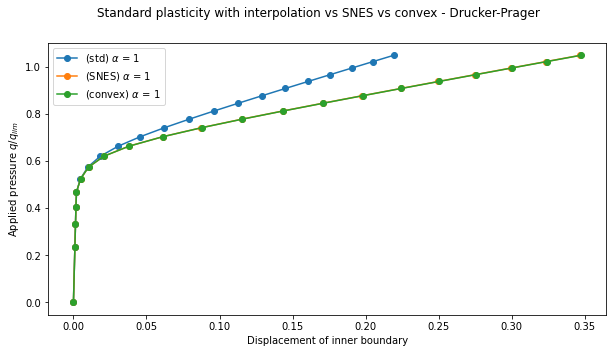

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_std_list[i][:, 0], results_std_list[i][:, 1], "-o", label=r'(std) $\alpha$ = ' + str(alpha))
    ax.plot(results_SNES_list[i][:, 0], results_SNES_list[i][:, 1], "-o", label=r'(SNES) $\alpha$ = ' + str(alpha))
    ax.plot(results_convex_list[i][:, 0], results_convex_list[i][:, 1], "-o", label=r'(convex) $\alpha$ = ' + str(alpha))
ax.set_xlabel("Displacement of inner boundary")
ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
ax.legend()
fig.suptitle('Standard plasticity with interpolation vs SNES vs convex - Drucker-Prager')

Text(0.5, 0.98, 'Standard plasticity with interpolation vs SNES vs convex - Drucker-Prager')

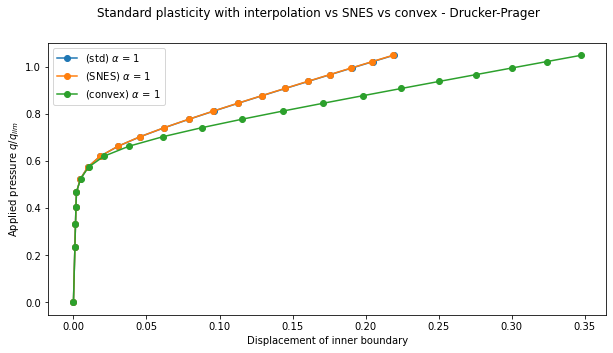

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_std_list[i][:, 0], results_std_list[i][:, 1], "-o", label=r'(std) $\alpha$ = ' + str(alpha))
    ax.plot(results_SNES_list[i][:, 0], results_SNES_list[i][:, 1], "-o", label=r'(SNES) $\alpha$ = ' + str(alpha))
    ax.plot(results_convex_list[i][:, 0], results_convex_list[i][:, 1], "-o", label=r'(convex) $\alpha$ = ' + str(alpha))
ax.set_xlabel("Displacement of inner boundary")
ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
ax.legend()
fig.suptitle('Standard plasticity with interpolation vs SNES vs convex - Drucker-Prager')

In [ ]:
alphas = [0.05, 0.1, 0.3, 0.5, 0.7, 1, 1.1, 1.3, 1.5, 2]

In [ ]:
results_SNES_list = []
for alpha in alphas:
    print(f'alpha = {alpha}')
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity_SNES = pf.StandardSNESDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results_SNES = plasticity_SNES.solve()
    results_SNES_list.append(results_SNES)

alpha = 0.05

  0 SNES Function norm 8.904703628988e-05 
  1 SNES Function norm 9.352557389794e-18 

nRes0 , 9.352557389793929e-18 
 Increment: 1, load = 0.0002537449238735671
  0 SNES Function norm 5.216254616949e-05 
  1 SNES Function norm 5.926559618708e-18 

nRes0 , 5.926559618707852e-18 
 Increment: 2, load = 0.00035884951272532715
  0 SNES Function norm 8.582025413172e-06 
  1 SNES Function norm 1.953264032247e-18 

nRes0 , 1.9532640322465793e-18 
 Increment: 3, load = 0.0004394991003117152
  0 SNES Function norm 4.442383244966e-06 
  1 SNES Function norm 1.558502378188e-18 

nRes0 , 1.5585023781876496e-18 
 Increment: 4, load = 0.0005074898477471342
  0 SNES Function norm 2.838927702956e-06 
  1 SNES Function norm 1.183758675863e-18 

nRes0 , 1.1837586758627823e-18 
 Increment: 5, load = 0.0005673908987268053
  0 SNES Function norm 2.016578081062e-06 
  1 SNES Function norm 1.104277473369e-18 

nRes0 , 1.1042774733685764e-18 
 Increment: 6, load = 0.000621545588311601
  0 SNES F

In [ ]:
results_convex_list = []
for alpha in alphas:
    print(f'alpha = {alpha}')
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity_convex = pf.ConvexPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results_convex = plasticity_convex.solve()
    results_convex_list.append(results_convex)

alpha = 0.05


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 6.335409561879999e-16, 7.114677619652282e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.868 (s)

nRes0 , 3.688449012024118e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 8.943073402034117e-16, 2.4246162473387175e-11
u 0.0014059006994497092 0.0 0.016926157154484988
rank#0: Time (mean return mapping) = 2.608 (s)

nRes0 , 2.83024647070041e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 1.0626341601849178e-15, 3.754564032446066e-11
u 0.0017218696713369131 0.0 0.020730224167323036
rank#0: Time (mean return mapping) = 2.456 (s)

nRes0 , 2.386008146205069e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.2636854567542964e-15, 5.296232784302016e-11
u 0.001988243836511617 0.0 0.023937201006730132
rank#0: Time (mean return mapping) = 2.539 (s)

nRes0 , 2.1021153758991766e-05 
 Increment: 5, load = 0.000

Text(0.5, 0.98, 'Standard plasticity with interpolation - Drucker-Prager')

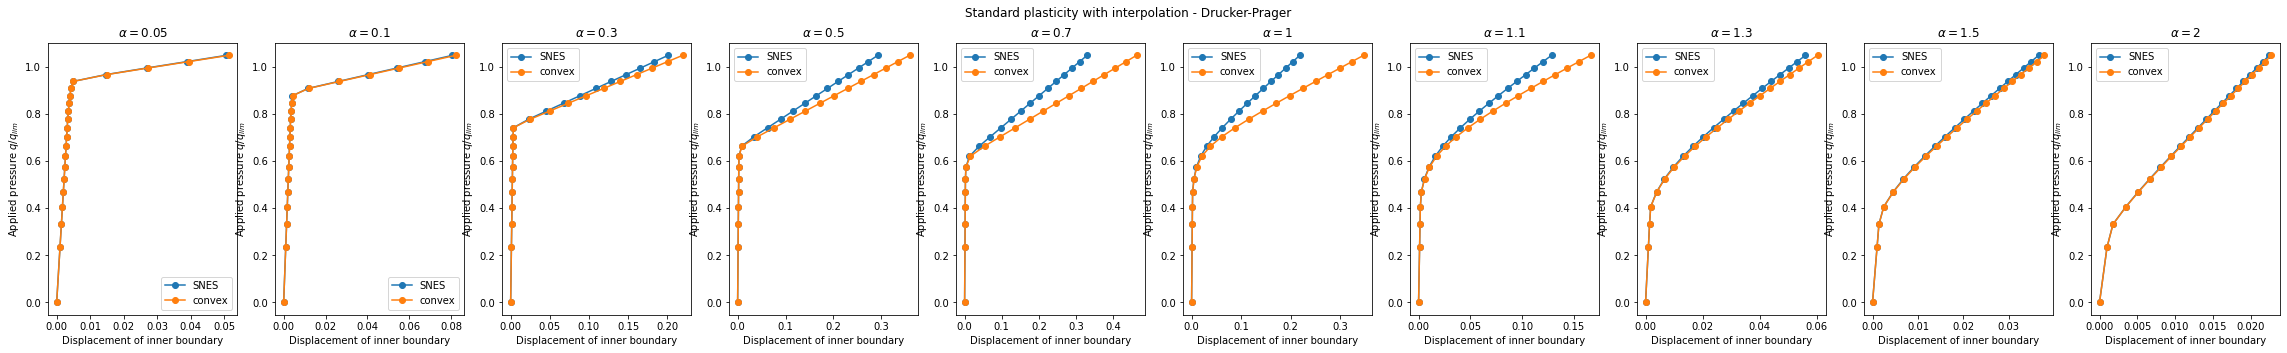

In [ ]:
fig, ax = plt.subplots(1, len(alphas), figsize=(40,5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_SNES_list[i][:, 0], results_SNES_list[i][:, 1], "-o", label='SNES')
    ax[i].plot(results_convex_list[i][:, 0], results_convex_list[i][:, 1], "-o", label='convex')
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")
    ax[i].legend()
    
fig.suptitle('Standard plasticity with interpolation - Drucker-Prager')

## Standard plasticity with interpolation

In [ ]:
results_list = []
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results = plasticity.solve()
    results_list.append(results)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.044 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.042 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.034 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.033 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

Text(0.5, 0.98, 'Standard plasticity with interpolation - Drucker-Prager')

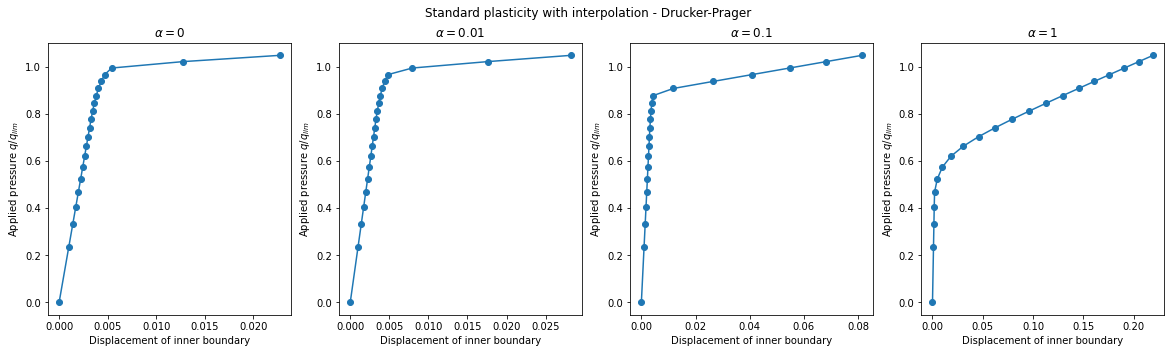

In [ ]:
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_list[i][:, 0], results_list[i][:, 1], "-o")
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")
    
fig.suptitle('Standard plasticity with interpolation - Drucker-Prager')

## Convex plasticity

In [ ]:
results_list = []
for alpha in alphas:
    DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
    material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
    plasticity = pf.ConvexPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
    _, results = plasticity.solve()
    results_list.append(results)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 6.333979021162877e-16, 7.113071119563424e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.599 (s)

nRes0 , 3.688449012024125e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 1.871393152572862e-12, 5.0736587288376e-08
    Residual: 1.9385926502878706e-18, 5.2558477668206165e-14
u 0.0014059006994497137 0.0 0.01692615715448422
rank#0: Time (mean return mapping) = 2.477 (s)

nRes0 , 2.8302464707225653e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 2.848770490202401e-12, 1.0065450199024916e-07
    Residual: 1.5085623426991559e-18, 5.3301447711513903e-14
u 0.0017218696713370229 0.0 0.02073022416732207
rank#0: Time (mean return mapping) = 2.264 (s)

nRes0 , 2.3860081462259375e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.236322222352133e-12, 1.3563751772898084e-07
    Residual: 1.5991003700101187e-18, 6.70199040

Text(0.5, 0.98, 'Convex plasticity - Drucker-Prager')

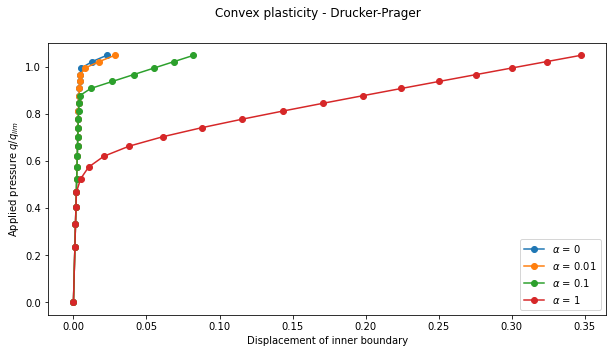

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, alpha in enumerate(alphas):
    ax.plot(results_list[i][:, 0], results_list[i][:, 1], "-o", label=r'$\alpha$ = ' + str(alpha))
ax.set_xlabel("Displacement of inner boundary")
ax.set_ylabel(r"Applied pressure $q/q_{lim}$")
ax.legend()
fig.suptitle('Convex plasticity - Drucker-Prager')

Text(0.5, 0.98, 'Convex plasticity - Drucker-Prager')

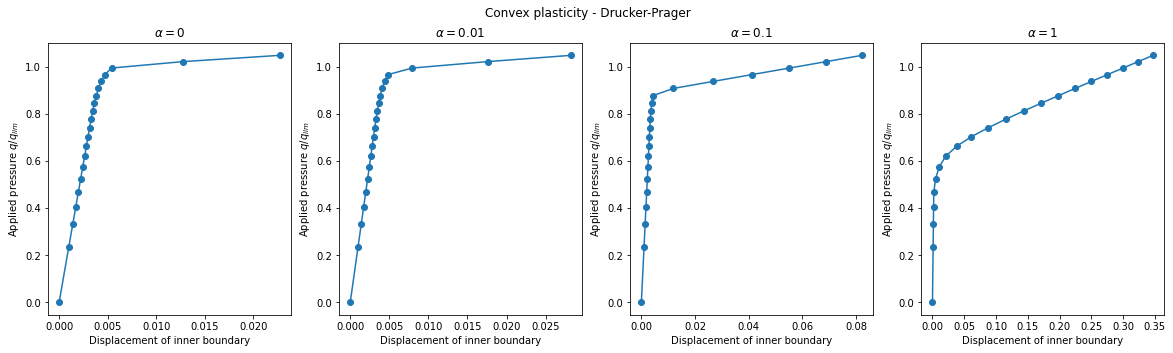

In [ ]:
fig, ax = plt.subplots(1, len(alphas), figsize=(20, 5))
for i, alpha in enumerate(alphas):
    ax[i].set_title(r'$\alpha = $' + str(alpha))
    ax[i].plot(results_list[i][:, 0], results_list[i][:, 1], "-o")
    ax[i].set_xlabel("Displacement of inner boundary")
    ax[i].set_ylabel(r"Applied pressure $q/q_{lim}$")

fig.suptitle('Convex plasticity - Drucker-Prager')

## Other calculations